## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1651
+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|            coeff_4|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|             res_4|           res_mean|    station|  total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|  392.4260121366621| -90.28280871726807|-173.86119095642724| 22

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00087851| 28.3378|   -82.26|     57.9|  392.4260121366621|
|USC00083316|   29.65|   -82.35|     52.1|-1127.5011953087064|
|USC00083321| 29.6333| -82.3667|     29.3|  339.3907048774236|
|USC00081046| 28.6164| -82.3658|     73.2|  386.2912957121724|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [7]:
import IPython
from IPython.display import display
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)
display(pdf)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
26,USC00080535,28.5500,-82.6333,14.9,8,-852.928829
25,USC00080598,29.7956,-82.9178,9.1,11,-1393.929266
38,USC00080940,27.4833,-82.5500,3.0,40,141.640689
12,USC00080945,27.4467,-82.5014,6.1,40,-214.092314
16,USC00081046,28.6164,-82.3658,73.2,88,200.986511
23,USC00081163,28.6664,-82.0894,22.9,43,-45.457015
17,USC00081310,26.5333,-82.1833,-999.9,26,331.981383
42,USC00081432,29.1333,-83.0500,3.0,65,-190.353184
41,USC00081632,27.9667,-82.7667,21.0,38,216.601445
33,USC00081635,27.9833,-82.8333,3.0,5,161.577623


In [8]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (24.6278, 30.1064, -83.3883, -82.0333)


In [10]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
color=[]
values=[]
i=0
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]

    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1000*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    color.append(get_color(_coef))
    values.append(_coef)
    circles.append(c)
    m.add_layer(c)
m    

In [14]:
for x,y in zip(values,color):
    print str(x)+" "+str(y)

-852.928829033 #00b0ff
-1393.92926563 #000080
141.640689015 #ff3f00
-214.092313829 #f4f802
200.986510614 #ff1e00
-45.4570152541 #ff9f00
331.981382685 #bb0000
-190.35318376 #ffea00
216.601445353 #ff1600
161.577622549 #ff3400
-1159.5915936 #0000ff
327.339452547 #bf0000
-228.132382694 #eeff09
-657.411212685 #2cffca
404.825160379 #8d0000
-806.462653661 #00c8ff
84.9790366237 #ff5d00
-579.256412271 #50ffa7
-1330.05950056 #0000a4
-893.136890135 #0098ff
-9.76203449936 #ff8d00
-819.909368517 #00c0ff
367.747621563 #a40000
393.843328224 #920000
81.8037298637 #ff5d00
-294.413703488 #d1ff26
-274.393611391 #dbff1c
-34.998348217 #ff9c00
371.797928117 #9f0000
340.398104441 #b60000
214.951491557 #ff1600
42.2131187336 #ff7300
-290.250949438 #d4ff23
186.63459058 #ff2500
408.143683909 #890000
427.487527943 #800000
-1183.52691678 #0000ff
-347.450964724 #baff3c
-1147.64577829 #0008ff
-577.694779546 #50ffa7
-1029.24323035 #004cff
-885.943770313 #009cff
-705.699401516 #16ffe1
130.386666428 #ff4300
-223.800717

In [15]:
sorted(values)

[-1393.9292656264013,
 -1330.0595005563364,
 -1183.5269167800113,
 -1159.5915935990392,
 -1147.645778287001,
 -1029.24323035019,
 -955.6173277981126,
 -893.1368901348195,
 -885.9437703130816,
 -852.9288290328053,
 -819.9093685170888,
 -806.4626536609533,
 -705.6994015161663,
 -657.4112126854956,
 -579.2564122705963,
 -577.6947795463341,
 -347.4509647239676,
 -294.4137034882195,
 -290.2509494382122,
 -274.3936113909139,
 -228.13238269428766,
 -223.80071766632594,
 -214.09231382870243,
 -190.35318376027695,
 -182.733884768551,
 -45.457015254054944,
 -34.99834821695056,
 -9.762034499363889,
 42.21311873359269,
 81.80372986371017,
 84.97903662371905,
 130.38666642778725,
 141.6406890147729,
 161.57762254870735,
 186.63459057994837,
 191.15350394699863,
 200.98651061361315,
 214.9514915569455,
 216.60144535336656,
 327.3394525468576,
 330.6920972537026,
 331.9813826852359,
 340.3981044413569,
 367.7476215634303,
 371.797928116547,
 393.84332822392935,
 404.8251603786332,
 408.143683909384,


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

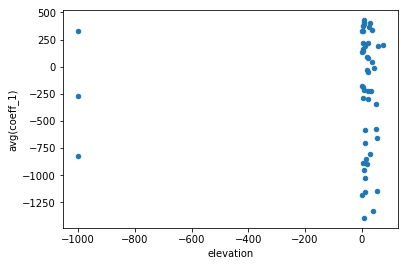

In [12]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [13]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']